TODO: Add Title
TODO: Add TOC
TODO: Add Introduction (include kaggle link in intro) - https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Goal

- Head of Business Development
    - What is the relationship between seller location and buyer location? Is this something we should pay attention to?
    - Where do you see opportunities for growth?
- VP, Customer Success
    - What does the data tell us about customer satisfaction?
- Head of Partnerships
    - Which sellers stand out as special and what are their characteristics?
    - Where do we have opportunities to expand our seller partnerships?


In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data and checking it's shape

In [301]:
# Load the dataset
# This is the core dataset. From each order you might find all other information.
df_orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")

# This dataset includes data about the items purchased within each order.
df_order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")

# This dataset includes data about the orders payment options.
df_order_payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")

# This dataset includes data about the reviews made by the customers.
# After a customer purchases the product from Olist Store a seller gets notified to fulfill that order.
# Once the customer receives the product, or the estimated delivery date is due,
# the customer gets a satisfaction survey by email where he can give a note for the purchase experience
# and write down some comments.
df_order_reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")

# This dataset includes data about the products sold by Olist.
df_products = pd.read_csv("../data/raw/olist_products_dataset.csv")

# This dataset includes data about the sellers that fulfilled orders made at Olist.
# Use it to find the seller location and to identify which seller fulfilled each product.
df_sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")

# This dataset has information Brazilian zip codes and its lat/lng coordinates.
# Use it to plot maps and find distances between sellers and customers.
df_geolocation = pd.read_csv("../data/raw/olist_geolocation_dataset.csv")

# This dataset has information about the customer and its location.
# Use it to identify unique customers in the orders dataset and to find the orders delivery location.
# At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders.
# The purpose of having a customer_unique_id on the dataset is to allow you to identify customers
# that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.
df_customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")

df_name_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

In [302]:
dfs = {"Orders": df_orders,
       "Order_items": df_order_items,
       "Order_Payments": df_order_payments,
       "Order_reviews": df_order_reviews,
       "Products": df_products,
       "Sellers": df_sellers,
       "Geolocation": df_geolocation,
       "Customers": df_customers,
       "Name_Translation": df_name_translation}

In [303]:
for key, value in dfs.items():
    print(f'The {key} dataset has {value.shape[0]} rows and {value.shape[1]} columns')

The Orders dataset has 99441 rows and 8 columns
The Order_items dataset has 112650 rows and 7 columns
The Order_Payments dataset has 103886 rows and 5 columns
The Order_reviews dataset has 99224 rows and 7 columns
The Products dataset has 32951 rows and 9 columns
The Sellers dataset has 3095 rows and 4 columns
The Geolocation dataset has 1000163 rows and 5 columns
The Customers dataset has 99441 rows and 5 columns
The Name_Translation dataset has 71 rows and 2 columns


In [304]:
def plotDistributionBar(df, columnName, top_n = 0):
    # TODO : Add documentation string
    percentages_all = round(df[columnName].value_counts(normalize=True)*100, 2)
    percentages = {}
    if top_n == 0:
        percentages = percentages_all
    else:
        if top_n < len(percentages_all) and top_n > 0:
            percentages = percentages_all[:top_n]

    plt.figure()
    if len(percentages_all) > 10:
        plt.figure(figsize=(15,5))
    graph = plt.bar(percentages.index, percentages.values)
    plt.title(f"Distribution of {columnName} in the dataset")
    plt.xticks(rotation=45)
    if len(percentages_all) > 10:
        plt.xticks(rotation=90)
    for p in graph:
        height=p.get_height()
        plt.annotate( "{}%".format(height),(p.get_x() + p.get_width()/2, height+.05),ha="center",va="bottom",fontsize=9)
    plt.show()

### 1. Orders dataset

In [305]:
df_orders.sample()

order_id                       customer_id  \
62947  d2856f6ebeb83a09908c18ce24946ab2  9ff101a7c75ef3fe50d8c95b96010b08   

      order_status order_purchase_timestamp    order_approved_at  \
62947    delivered      2017-12-14 09:26:35  2017-12-14 09:35:22   

      order_delivered_carrier_date order_delivered_customer_date  \
62947          2017-12-20 19:54:48           2018-01-04 20:58:43   

      order_estimated_delivery_date  
62947           2018-01-11 00:00:00

In [306]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


We can see that date  have type object, let's change it to datetime

In [307]:
df_orders['order_purchase_timestamp'] = df_orders['order_purchase_timestamp'].astype('datetime64[ns]')
df_orders['order_approved_at'] = df_orders['order_approved_at'].astype('datetime64[ns]')
df_orders['order_delivered_carrier_date'] = df_orders['order_delivered_carrier_date'].astype('datetime64[ns]')
df_orders['order_delivered_customer_date'] = df_orders['order_delivered_customer_date'].astype('datetime64[ns]')
df_orders['order_estimated_delivery_date'] = df_orders['order_estimated_delivery_date'].astype('datetime64[ns]')

In [308]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [309]:
#checking the null values
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [310]:
df_orders.isnull().sum() / len(df_orders.index) * 100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

- 0.16% of the values are missing for `order_approved_at`.
- 1.79% of the values are missing for `order_delivered_carrier_date`.
- 2.98% of the values are missing for `order_delivered_customer_date`.

`order_approved_at` - drop the column as it is not useful for any of the questions we want to answer
Let's check how many null values are present for orders whose status says 'delivered'

In [311]:
df_orders_delivered = df_orders.loc[df_orders['order_status'] == "delivered"]
df_orders_delivered.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [312]:
df_orders_delivered.loc[df_orders_delivered['order_delivered_customer_date'].isnull()]

order_id                       customer_id  \
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
20618  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
43834  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
79263  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
82868  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
98038  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp   order_approved_at  \
3002     delivered      2017-11-28 17:44:07 2017-11-28 17:56:40   
20618    delivered      2018-06-20 06:58:43 2018-06-20 07:19:05   
43834    delivered      2018-07-01 17:05:11 2018-07-01 17:15:12   
79263    delivered      2018-07-01 22:05:55 2018-07-01 22:15:14   
82868    delivered      2018-07-01 21:14:02 2018-07-01 21:29:54   
92643    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   
97647    delivered      2018-06-08 12:09:39 2018-06-08 12:36:39   
98038    delivered      2018-06-27 16:09:12 2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
3002           2017-11-30 18:12:23                           NaT   
20618          2018-06-25 08:05:00                           NaT   
43834          2018-07-03 13:57:00                           NaT   
79263          2018-07-03 13:57:00                           NaT   
82868          2018-07-03 09:28:00                           NaT   
92643                          NaT                           NaT   
97647          2018-06-12 14:10:00                           NaT   
98038          2018-07-03 19:26:00                           NaT   

      order_estimated_delivery_date  
3002                     2017-12-18  
20618                    2018-07-16  
43834                    2018-07-30  
79263                    2018-07-30  
82868                    2018-07-24  
92643                    2017-06-23  
97647                    2018-06-26  
98038                    2018-07-19

In [313]:
(df_orders_delivered['order_delivered_customer_date'] - df_orders_delivered['order_delivered_carrier_date']).mean()

Timedelta('9 days 07:55:37.665809741')

In [314]:
(df_orders_delivered['order_delivered_customer_date'] - df_orders_delivered['order_delivered_carrier_date']).mode()

0   3 days
dtype: timedelta64[ns]

In [315]:
diff_approved=((df_orders_delivered['order_delivered_customer_date'] - df_orders_delivered['order_delivered_carrier_date'])/np.timedelta64(1, 'D'))

(array([3.7851e+04, 5.5382e+04, 2.8160e+03, 3.0900e+02, 4.5000e+01,
        2.3000e+01, 1.5000e+01, 4.0000e+00, 1.7000e+01, 7.0000e+00]),
 array([-16.09616898,   6.03254514,  28.16125926,  50.28997338,
         72.4186875 ,  94.54740162, 116.67611574, 138.80482986,
        160.93354398, 183.0622581 , 205.19097222]),
 <BarContainer object of 10 artists>)

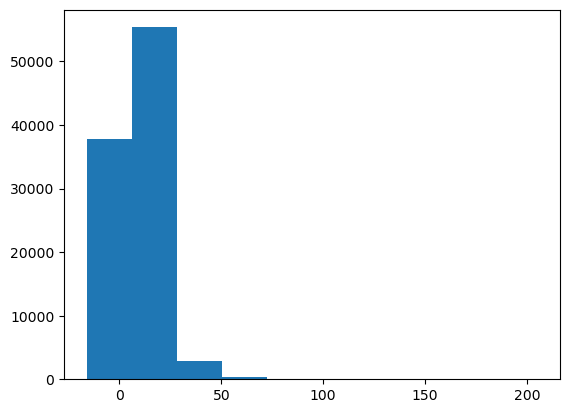

In [316]:
plt.figure()
plt.hist(diff_approved)

Imputing values for `order_approved_at`

In [317]:
# Find the mean of the difference between order_purchase_timestamp and order_approved_at
(df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).mean()

Timedelta('0 days 10:25:08.739486910')

In [318]:
# Find the mean of the difference between order_purchase_timestamp and order_approved_at
(df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).median()

Timedelta('0 days 00:20:36')

In [319]:
#calculating difference in days between the purchase date and the columns with NANS
diff_est=((df_orders['order_estimated_delivery_date']-df_orders['order_purchase_timestamp'])/np.timedelta64(1, 'D')).astype(int)
diff_approved=((df_orders['order_approved_at']-df_orders['order_purchase_timestamp'])/np.timedelta64(1, 'D'))
diff_logist=((df_orders['order_delivered_carrier_date']-df_orders['order_purchase_timestamp'])/np.timedelta64(1, 'D'))
diff_del=((df_orders['order_delivered_customer_date']-df_orders['order_purchase_timestamp'] )/np.timedelta64(1, 'D'))

In [320]:
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [321]:
#checking duplicates across rows
df_orders.duplicated().sum()

0

In [322]:
#checking duplicates across columns
df_orders.columns.has_duplicates

False

In [323]:
# checking unique values for order_id
df_orders['order_id'].nunique()

99441

#### Quick findings:

- Orders dataset has information about the orders. Each order contains a customer id, order status, purchase timestamp and actual and estimated delivery information.
- We have a total of 99441 unique orders which is the primary key for this table.  
- We fixed the data type of 5 fields to be datetime instead of object.
- There are no duplicates across rows or columns.
- There are null values in 3 fields - `order_approved_at`, `order_delivered_carrier_date`, and `order_delivered_customer_date`.

We have null values in 3 columns: order_approved_at, order_delivered_carrier_date, and order_delivered_customer_date. Does it have to do anything with the Order status?

In [324]:
df_orders['order_status'].nunique()

8

In [325]:
df_orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

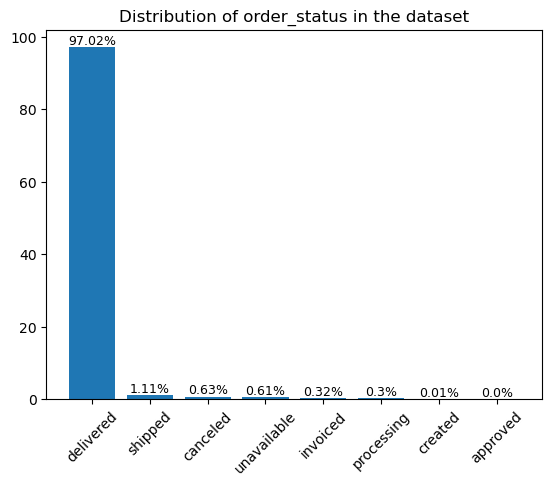

In [326]:
plotDistributionBar(df_orders,'order_status')

We have a total of eight order status. Our data has 97% of orders that were delivered. Only 0.63% of orders were cancelled. There are diferent order status that specify at which stage our order is.

We want to understand if there is any relationship with missing values and the order status. We will filter the rows with missing values and check what is the status of that order.

In [327]:
#checking the status where all the values are missing
df_orders.loc[df_orders['order_delivered_customer_date'].isnull() & \
           df_orders['order_delivered_carrier_date'].isnull() & \
           df_orders['order_approved_at'].isnull() ]['order_status'].value_counts()

order_status
canceled    141
created       5
Name: count, dtype: int64

TODO: figure out what to  do with the null values

### 2. Order items dataset

In [328]:
df_order_items.sample(5)

order_id  order_item_id  \
50167  72012d986d81cc09a1e838c7a1f829e7              1   
83923  bea1d77e861b4f44276f02d599d25705              1   
63827  91c75b7ba1ec17918b96773bc0f8f443              1   
27778  3f3410465f157511bd8a870e53348d17              1   
90666  cde001ad61a8e40ea8feff0ea31f9ea3              1   

                             product_id                         seller_id  \
50167  d5b703c271f43f9c588a6f512a00f77e  fa40cc5b934574b62717c68f3d678b6d   
83923  5a3320037d5922a7708647c81ecc1f15  b6d44737c043328708f6749c2dbe50bd   
63827  672cd55beec76a54b88a865280fd9e5a  45c20d94d9171b0bcfab3c955e47d67b   
27778  086351823300e0339f6955b27998c186  0c8380b62e38e8a1e6adbeba7eb9688c   
90666  a1d29fcea65a08f06b17d824306628cc  10ff823eda2b032e2c93d17a7d294736   

       shipping_limit_date   price  freight_value  
50167  2017-08-08 20:42:58   34.90          14.10  
83923  2017-05-26 14:30:11   75.00          21.02  
63827  2017-05-11 13:50:15    5.99          16.05  
27778  2017-04-02 23:23:37  149.90          17.79  
90666  2017-11-21 03:46:35   77.40          21.03

In [329]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Fix the data type of `shipping_limit_date`

In [330]:
df_order_items['shipping_limit_date'] = df_order_items['shipping_limit_date'].astype('datetime64[ns]')

In [331]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [332]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [333]:
df_order_items.duplicated().sum()

0

In [334]:
df_order_items.columns.has_duplicates

False

In [335]:
#checking the unique values in column order_id and order_item_id
df_order_items['order_id'].nunique()

98666

In [336]:
df_order_items['order_item_id'].nunique()

21

In [337]:
df_order_items['order_item_id'].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

`order_item_id` seems to be the number of items in one order

In [338]:
df_order_items.loc[(df_order_items['order_item_id'] == 21)]

order_id  order_item_id  \
57317  8272b63d03f5f79c56e9e4120aec44ef             21   

                             product_id                         seller_id  \
57317  79ce45dbc2ea29b22b5a261bbb7b7ee7  2709af9587499e95e803a6498a5a56e9   

      shipping_limit_date  price  freight_value  
57317 2017-07-21 18:25:23    7.8           6.57

In [339]:
df_orders.loc[df_orders['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

order_id                       customer_id  \
88849  8272b63d03f5f79c56e9e4120aec44ef  fc3d1daec319d62d49bfb5e1f83123e9   

      order_status order_purchase_timestamp   order_approved_at  \
88849    delivered      2017-07-16 18:19:25 2017-07-17 18:25:23   

      order_delivered_carrier_date order_delivered_customer_date  \
88849          2017-07-20 15:45:53           2017-07-31 18:03:02   

      order_estimated_delivery_date  
88849                    2017-07-28

In [340]:
99441 - 98666

775

The Orders dataset has 99441 unique order ids and so it is the primary key there. The  order items table has only 98666 unique values for order ids. Does this mean that 775 order ids are missing from this table? I wonder whether that is because the order status is different in the orders table. Do some more investigation here.

#### Findings

TODO : Fill this in

### 3. Order payments dataset

In [341]:
df_order_payments.sample(5)

order_id  payment_sequential payment_type  \
54023  d8c288d0fed5e08752d14664f564075a                   1       boleto   
88982  c05b9a60de6b80604843d2f4d40c8a67                   2      voucher   
80000  92bf30cf8f385d2a50d5532b07585a1c                   1       boleto   
34759  3cd7db83ec0d0241ff01cd50c1571acb                   1  credit_card   
19326  ad7ddb009f1bcd6c40cb1106471c292c                   1  credit_card   

       payment_installments  payment_value  
54023                     1          42.78  
88982                     1          25.00  
80000                     1         141.53  
34759                     8         385.74  
19326                     8         502.12

In [342]:
df_order_payments['payment_type'].value_counts(normalize=True)*100

payment_type
credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: proportion, dtype: float64

In [343]:
df_order_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [344]:
df_order_payments.duplicated().sum()

0

In [345]:
df_order_payments.columns.has_duplicates

False

In [346]:
df_order_payments['order_id'].nunique()

99440

In [347]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


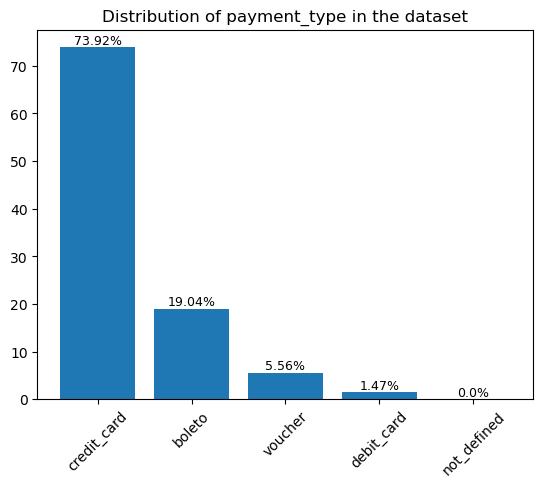

In [348]:
plotDistributionBar(df_order_payments,'payment_type')

#### Quick findings:

- Payments dataset has information about the way customer made payment for each order.
- We have payment information for 99440 unique order ids.
- This dataset has three columns of object datatype and two column with numeric datatype.
- There are no duplicates across rows or columns.
- There are no null values.
- `order_id` is the foreign key in this table.

### 4. Order reviews dataset

In [349]:
df_order_reviews.sample(5)

review_id                          order_id  \
94850  ca42bfb53eb4a0f39eceb790858878c9  62fe29a53926ef67e73c4b5f3e1ba6f3   
67809  df147e480aba991514e34c5b44b0d989  1c38314597f39a117548efb308041b76   
1360   b8e4ab342595a5a9de5c33fcd1e86ade  a147b97f47abbdb02f67ea00da442cd8   
86835  6a9d89e9a629af25b6f0e4767f726376  983d1042c129f87546062d2d27f73020   
81928  6ac6caf42beaa679b394b3e4ec9680f4  f8cc76d89295e1bdf2215efe69872481   

       review_score review_comment_title  \
94850             4                  NaN   
67809             3                  NaN   
1360              5                  NaN   
86835             4                  NaN   
81928             5                  NaN   

                                  review_comment_message review_creation_date  \
94850                                                NaN  2018-01-10 00:00:00   
67809  O produto muito bom, só que veio com 3 arranhõ...  2017-12-29 00:00:00   
1360                                                 NaN  2018-08-11 00:00:00   
86835                                                NaN  2017-10-12 00:00:00   
81928                                                NaN  2017-12-21 00:00:00   

      review_answer_timestamp  
94850     2018-01-10 21:34:16  
67809     2018-01-01 18:37:32  
1360      2018-08-13 22:47:16  
86835     2017-10-17 15:49:45  
81928     2017-12-22 00:22:57

In [350]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [351]:
df_order_reviews.shape

(99224, 7)

In [352]:
df_order_reviews['order_id'].nunique()

98673

- 98673 order ids have reviews
- There are multiple rows for some order ids - total rows are 99224

In [353]:
df_order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Let's fix the data type for date and timestamp

In [354]:
df_order_reviews['review_creation_date'] = df_order_reviews['review_creation_date'].astype('datetime64[ns]')
df_order_reviews['review_answer_timestamp'] = df_order_reviews['review_answer_timestamp'].astype('datetime64[ns]')

In [355]:
df_order_reviews.duplicated().sum()

0

In [356]:
df_order_reviews.columns.has_duplicates

False

In [357]:
df_order_reviews['review_score'].nunique()

5

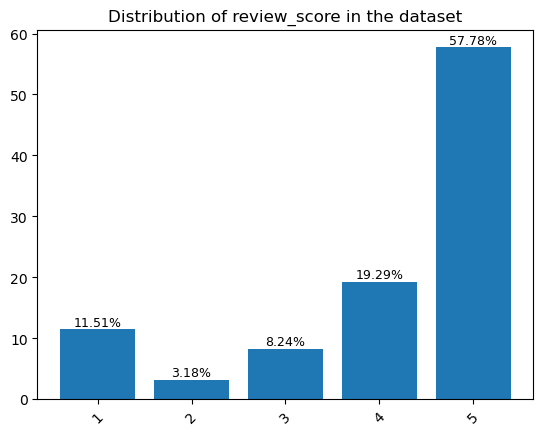

In [358]:
plotDistributionBar(df_order_reviews, 'review_score')

Since the reviews are in Portugese, we will not be using their content for any analysis.

In [359]:
df_order_reviews['review_id'].nunique()

98410

#### Quick findings


- Reviews dataset has information about reviews given by the customers. It consists of review score, comment, review creation date and review submission timestamp.
- We have a total of 99224 review ids of which 98410 are the unique review ids. It means there are 814 reviews which have been resubmitted. These are the ones that need to be tackled.
- We have 98673 unique order ids and 98410 unique review ids. It means that there are 263 reviews with same order id. It is possible that these reviews are for different products ordered under same order id.
- There are no duplicates across rows or columns.
- 57.8 % of the dataset has a review score of 5.

### 5. Products dataset

In [360]:
df_products.shape

(32951, 9)

In [361]:
df_products.sample(5)

product_id  product_category_name  \
26958  efb23bb2d728864f9d7d3cdad802ca87             automotivo   
22718  9d82a263e18f0b5ede827b8dd9825e74        cama_mesa_banho   
21691  186d7d472f062ca6ef30689faa935d2e  utilidades_domesticas   
15889  34952b816a67556375be2aac9cab263d             perfumaria   
9216   fcffe8b68efdfe24c139e44753dc505e             cool_stuff   

       product_name_lenght  product_description_lenght  product_photos_qty  \
26958                 58.0                       292.0                 2.0   
22718                 49.0                       215.0                 2.0   
21691                 55.0                       281.0                 1.0   
15889                 33.0                       519.0                 3.0   
9216                  52.0                       998.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
26958            2950.0               30.0               10.0   
22718            1600.0               35.0               15.0   
21691             250.0               25.0               25.0   
15889             100.0               20.0               20.0   
9216             2600.0               42.0               25.0   

       product_width_cm  
26958              60.0  
22718              23.0  
21691              25.0  
15889              20.0  
9216               15.0

In [362]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Let's fix the typo in the column names 'lenght' -> 'length'

In [363]:
df_products['product_name_length'] = df_products['product_name_lenght']
df_products['product_description_length'] = df_products['product_description_lenght']
df_products.drop(columns=['product_name_lenght','product_description_lenght'], inplace=True)
df_products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_photos_qty          32341 non-null  float64
 3   product_weight_g            32949 non-null  float64
 4   product_length_cm           32949 non-null  float64
 5   product_height_cm           32949 non-null  float64
 6   product_width_cm            32949 non-null  float64
 7   product_name_length         32341 non-null  float64
 8   product_description_length  32341 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [364]:
df_products['product_id'].nunique()

32951

In [365]:
df_products['product_category_name'].nunique()

73

In [366]:
df_products.isna().sum().sort_values(ascending=False)

product_category_name         610
product_photos_qty            610
product_name_length           610
product_description_length    610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
product_id                      0
dtype: int64

In [367]:
(df_products.isna().sum() / df_products.shape[0] * 100).sort_values(ascending=False)

product_category_name         1.851234
product_photos_qty            1.851234
product_name_length           1.851234
product_description_length    1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
product_id                    0.000000
dtype: float64

#### Quick findings

- Products dataset has information about product categories, and their attributes.
- `product_id` is the primary key of the dataset.
- There are 73 unique product categories.
- `product_category_name` is in Portugese
- 610 products don't have the `product_category_name`, 1.85% of the dataset
- There are few null values and we need to impute these values.

Imputing missing values

- We have seen that the rows which are missing values, a majority are missing a categorical data ie. product category name and respective, description, name length and photo quantities which are numerical.
- We can find out the rows which are exactly matching the columns (weight, lenght, height, width) and we can fill the null value with the product category name of the matching category. We can fill rest of the values ie product description lenght, product name lenght and photo quantity with either mean, median or mode of that known category.
- If there are multiple matches for product category, we can filter out the category with most occuring match.
- If there is no match we can create a separate category 'other' and fill rest of the values with either of mean, median or mode (determined after making a boxplot).
- We will separate the rows from products dataframe with the missing values in separate dataframe (missing) and create another dataframe (all_values) where there is no null values.
- We will find the element wise match of missing with all_values.
- We only have two rows with missing product weight, height, length and width. We will use mean to fill these values.

<Axes: xlabel='product_category_name'>

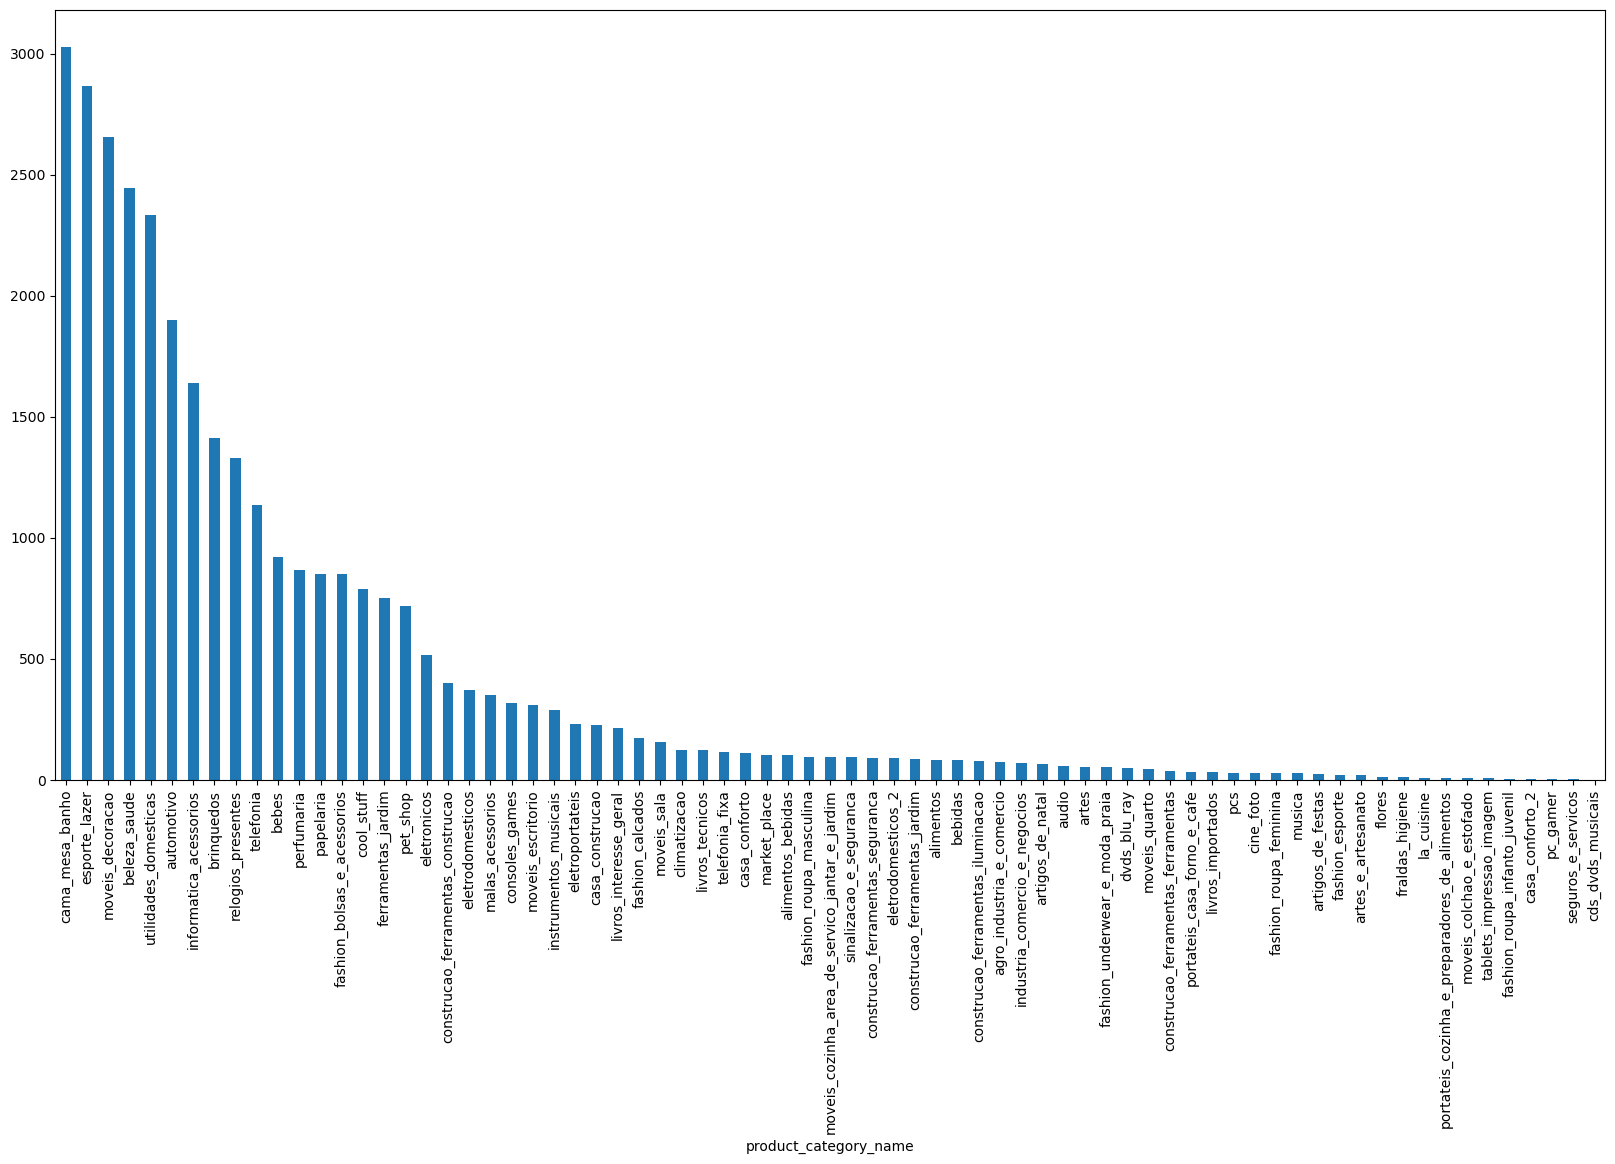

In [368]:
# quickly checking the categories
df_products['product_category_name'].value_counts().plot(kind='bar', figsize=(20, 10),)

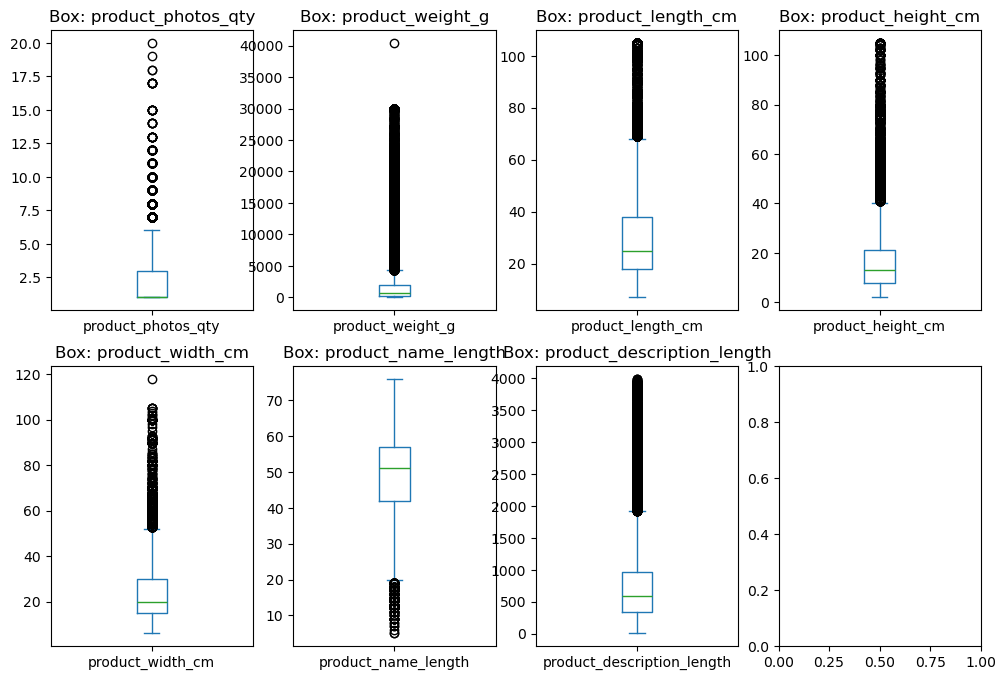

In [369]:
# making box plots for all the numeric columns
fig, axes = plt.subplots(2,4, figsize=(12,8))
numeric = df_products.select_dtypes(include=np.number).columns
for i, val in enumerate(numeric):
    df_products[val].plot.box(title=f'Box: {val}', ax=axes.flat[i])

We can see from the box plot that there are a bunch of outliers in every box plot. We can use median to impute the missing values.

In [370]:
#separating the missing values and known values
missing = df_products[df_products['product_category_name'].isnull()]
all_values = df_products[df_products['product_category_name'].notnull()]

#getting the column names for 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
col = missing.columns[5:]
col

Index(['product_height_cm', 'product_width_cm', 'product_name_length',
       'product_description_length'],
      dtype='object')

In [371]:
#checking for match and saving the index and values in a dictionary
match = dict()
for i in missing.index:
    if ((all_values.iloc[:, 5] == missing.loc[i, col[0]]) & (all_values.iloc[:, 6]==missing.loc[i, col[1]]) & (all_values.iloc[:, 7]==missing.loc[i, col[2]]) & (all_values.iloc[:, 8]==missing.loc[i, col[3]])).sum()>0:
        #saving the product category which is most occuring
        match[i]=all_values[(all_values.iloc[:, 5]==missing.loc[i, col[0]]) & (all_values.iloc[:, 6]==missing.loc[i, col[1]]) & (all_values.iloc[:, 7]==missing.loc[i, col[2]]) & (all_values.iloc[:, 8]==missing.loc[i, col[3]])]['product_category_name'].value_counts().head(1).index
    else:
        match[i]='empty'

In [372]:
#imputing the missing values
for i in match.keys():
    if match[i]!='empty':
        #where there is a match we are filling the value with median of columns for the category we are assigning
        df_products.loc[i, 'product_category_name']=match[i][0]
        df_products.loc[i, 'product_name_length']=round(df_products[df_products['product_category_name']== match[i][0]]['product_name_length'].median())
        df_products.loc[i, 'product_description_length']=round(df_products[df_products['product_category_name']== match[i][0]]['product_description_length'].median())
        df_products.loc[i, 'product_photos_qty']=round(df_products[df_products['product_category_name']== match[i][0]]['product_photos_qty'].median())
    else:
        #for no match we are filling with other
        df_products.loc[i, 'product_category_name']='Other'
        df_products.loc[i, 'product_name_length']=round(df_products['product_name_length'].median())
        df_products.loc[i, 'product_description_length']=round(df_products['product_description_length'].median())
        df_products.loc[i, 'product_photos_qty']=round(df_products['product_photos_qty'].median())

df_products['product_weight_g']=df_products['product_weight_g'].fillna(round(df_products['product_weight_g'].mean()))
df_products['product_length_cm']=df_products['product_length_cm'].fillna(round(df_products['product_length_cm'].mean()))
df_products['product_height_cm']=df_products['product_height_cm'].fillna(round(df_products['product_height_cm'].mean()))
df_products['product_width_cm']=df_products['product_width_cm'].fillna(round(df_products['product_width_cm'].mean()))

In [373]:
df_products.isna().sum()

product_id                    0
product_category_name         0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
product_name_length           0
product_description_length    0
dtype: int64

### 6. Sellers dataset

In [374]:
df_sellers.shape

(3095, 4)

In [375]:
df_sellers.sample(5)

seller_id  seller_zip_code_prefix  \
2408  2e2f44824ab87a0cb961f68bf4073e7f                   82315   
2493  218d46b86c1881d022bce9c68a7d4b15                   14070   
53    ef990a83bbea832f36ebe81376335aa8                   89214   
333   32f83ffe11cd40f7adcf4eef171f52d9                   97502   
1514  b410bdd36d5db7a65dcd42b7ead933b8                   74645   

         seller_city seller_state  
2408        curitiba           PR  
2493  ribeirao preto           SP  
53         joinville           SC  
333       uruguaiana           RS  
1514         goiania           GO

In [376]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [377]:
df_sellers['seller_id'].nunique()

3095

In [378]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [379]:
df_sellers.duplicated().sum()

0

In [380]:
df_sellers.columns.has_duplicates

False

In [381]:
df_sellers['seller_state'].nunique()

23

In [382]:
df_sellers['seller_city'].nunique()

611

<Figure size 640x480 with 0 Axes>

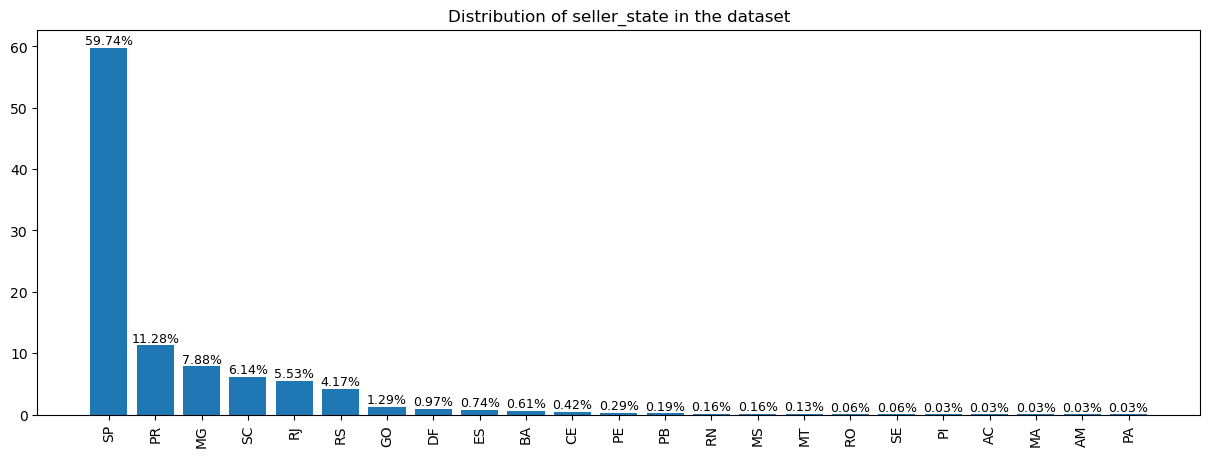

In [383]:
plotDistributionBar(df_sellers, 'seller_state')

- `seller_id` is the primary key, with 3095 unique values
- There are no null values
- There are no duplicates
- Sellers are from 23 states. Brazil has 26 states in all.
- About 60 percent of the sellers are from the south eastern state of Sao Paulo. A Google search shows that Sao Paulo is the most populous state in Brazil, accounting for about 21.8 percent of the country's population. It is also the richest state in Brazil, contributing to 33.9%  of the country's GDP.

### 7. Customers dataset

In [384]:
df_customers.shape

(99441, 5)

In [385]:
df_customers.sample(5)

customer_id                customer_unique_id  \
94657  a929dc93107a35a8f1e62177386711c6  d6b45f0072a17a85ffbeb9db88aae570   
27113  7f0c5c75576d4445ce6793cc0083c358  d7dbbc7712693c0578ead69f29911162   
8423   3a11da5254e67ef5ac37fd13c72126ec  f86b5e68941ef31c1c45eceb072eb6e4   
69983  91f92cfee46b79581b05aa974dd57ce5  9eca552063680b7cd2ed0e8aea002b21   
30479  aeaa3e7664211a50657bc516db596887  ee0e744d5d1a2a0cb5a1920ef02b8f3c   

       customer_zip_code_prefix        customer_city customer_state  
94657                     40243             salvador             BA  
27113                     13219              jundiai             SP  
8423                      17880              irapuru             SP  
69983                     81280             curitiba             PR  
30479                      6541  santana de parnaiba             SP

In [386]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [387]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [388]:
df_customers.duplicated().sum()

0

In [389]:
df_customers.columns.has_duplicates

False

In [390]:
df_customers['customer_id'].nunique()

99441

In [391]:
df_customers['customer_unique_id'].nunique()

96096

In [392]:
99441 - 96096

3345

In [393]:
#percentage of repeat customers
96096/99441

0.9663619633752677

There are some repeat customers, but most are new.

In [394]:
df_customers['customer_state'].nunique()

27

In [395]:
plotDistributionBar(df_customers, 'customer_state')

<Figure size 640x480 with 0 Axes>

#### Quick findings

- `customer_id` is the primary key for this dataset.
- We have a total of 96096 unique customer ids. It shows that we have around 96.6 % of new customers. Only 3.4% of the customers have made repeat purchase from the olist platform. It is because olist was founded in 2015 and they started selling online in 2016. The data we downloaded from Kaggel is from 2016 to 2018, when it was fairly new thus we only have new customers.
- There are no duplicates across rows or columns.
- There is no null value.
- Sao Paulo has the largest percentage of customers.

### 8. Product category name translation dataset

In [396]:
df_name_translation.shape

(71, 2)

In [397]:
df_name_translation.sample(5)

product_category_name product_category_name_english
46                              artes                           art
12                          papelaria                    stationery
43  construcao_ferramentas_iluminacao     construction_tools_lights
10                  alimentos_bebidas                    food_drink
55             fashion_roupa_feminina        fashio_female_clothing

In [398]:
df_name_translation.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

In [399]:
df_name_translation.duplicated().sum()

0

There were 73 unique values of product_category names in the products dataset, and here we have only 71 unique values. Let's try to find out which categories are missing their english translation.

In [400]:
missing_translations = set(df_products['product_category_name']) - set(df_name_translation['product_category_name'])
missing_translations

{'Other', 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [401]:
df_products.loc[df_products['product_category_name'] == 'pc_gamer'].value_counts().sum()

3

In [402]:
df_products.loc[df_products['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'].value_counts().sum()

10

Add the 2 categories with their translation to the table

In [403]:
df_name_translation.loc[len(df_name_translation.index)] = ['pc_gamer', 'pc_gamer']
df_name_translation.loc[len(df_name_translation.index)] = ['portateis_cozinha_e_preparadores_de_alimentos', 'portable_kitchen_gadgets']
df_name_translation.loc[len(df_name_translation.index)] = ['Other', 'other']

In [404]:
df_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          74 non-null     object
 1   product_category_name_english  74 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


### 9. Geolocation dataset

In [405]:
df_geolocation.shape

(1000163, 5)

In [406]:
df_geolocation.sample(5)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
294719                        13104       -22.860971       -46.977421   
603533                        35700       -19.438182       -44.246650   
921274                        89035       -26.906827       -49.084604   
605704                        35931       -19.834943       -43.182245   
598793                        35640       -19.225522       -44.992450   

       geolocation_city geolocation_state  
294719         campinas                SP  
603533      sete lagoas                MG  
921274         blumenau                SC  
605704   joao monlevade                MG  
598793           pompeu                MG

In [407]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [408]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [409]:
df_geolocation.duplicated().sum()

261831

There are many duplicates here, we can drop that, keeping only the first of the matching row.

In [410]:
df_geolocation.drop_duplicates(keep='first', inplace=True)

In [411]:
#checking duplicates across rows
df_geolocation.duplicated().sum()

0

#### Quick findings

### Merging the dataset

#### Merging product_category_translation with products

joining the product category with english names of the products and dropping the original product category name with names in portugese.

In [412]:
print(df_products.shape)
print(df_name_translation.shape)
df_products_final = pd.merge(left=df_products, right=df_name_translation, on='product_category_name', how='left')
print(df_products_final.shape)

(32951, 9)
(74, 2)
(32951, 10)


In [413]:
df_products_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32951 non-null  object 
 2   product_photos_qty             32951 non-null  float64
 3   product_weight_g               32951 non-null  float64
 4   product_length_cm              32951 non-null  float64
 5   product_height_cm              32951 non-null  float64
 6   product_width_cm               32951 non-null  float64
 7   product_name_length            32951 non-null  float64
 8   product_description_length     32951 non-null  float64
 9   product_category_name_english  32951 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [414]:
# drop columns that are not relevant to our analysis
df_products_final.drop(columns=['product_category_name', 'product_photos_qty', 'product_name_length', 'product_description_length'], inplace=True)

# confirm that columns were dropped
df_products_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_weight_g               32951 non-null  float64
 2   product_length_cm              32951 non-null  float64
 3   product_height_cm              32951 non-null  float64
 4   product_width_cm               32951 non-null  float64
 5   product_category_name_english  32951 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [415]:
df_products_final.isna().sum()

product_id                       0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

In [416]:
#Saving the final dataset to csv
df_products_final.to_csv('../data/final/products_final_dataset.csv', index=False)

We will be joining the tables to get a master table for addressing the business problem of Sales prediction.

Starting from the orders dataset, we will first join the order_items and then the products dataset.

Merging Orders and Order_items

In [417]:
print(df_orders.shape)
print(df_order_items.shape)
df_orders_final = pd.merge(left=df_orders, right= df_order_items, on= 'order_id', how='inner')
print(df_orders_final.shape)

(99441, 8)
(112650, 7)
(112650, 14)


In [418]:
df_orders_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [419]:
df_orders_final.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

Next we will join the products table.

Merging Products table with Order_final

In [420]:
print(df_orders_final.shape)
print(df_products_final.shape)
df_order_prod = pd.merge(left=df_orders_final, right=df_products_final, on='product_id', how='inner')
print(df_order_prod.shape)

(112650, 14)
(32951, 6)
(112650, 19)


In [421]:
df_order_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [422]:
df_order_prod.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
dtype: int64

Merging Sellers datset with the df_order_prod

In [423]:
print(df_order_prod.shape)
print(df_sellers.shape)
df_order_prod_seller = pd.merge(left=df_order_prod, right=df_sellers, on='seller_id', how='left')
print(df_order_prod_seller.shape)

(112650, 19)
(3095, 4)
(112650, 22)


In [424]:
df_order_prod_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [425]:
df_order_prod_seller.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
dtype: int64

Merging Customer dataset

In [426]:
print(df_order_prod_seller.shape)
print(df_customers.shape)
df_orders_with_cust = pd.merge(left=df_order_prod_seller, right=df_customers, on='customer_id', how='left')
print(df_orders_with_cust.shape)

(112650, 22)
(99441, 5)
(112650, 26)


In [427]:
df_orders_with_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [428]:
df_orders_with_cust.isna().sum().sort_values(ascending=False)

order_delivered_customer_date    2454
order_delivered_carrier_date     1194
order_approved_at                  15
order_id                            0
product_length_cm                   0
customer_city                       0
customer_zip_code_prefix            0
customer_unique_id                  0
seller_state                        0
seller_city                         0
seller_zip_code_prefix              0
product_category_name_english       0
product_width_cm                    0
product_height_cm                   0
freight_value                       0
product_weight_g                    0
customer_id                         0
price                               0
shipping_limit_date                 0
seller_id                           0
product_id                          0
order_item_id                       0
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
customer_state                      0
dtype: int64

Merging the Reviews dataset

In [429]:
print(df_orders_with_cust.shape)
print(df_order_reviews.shape)
df_olist_merged = pd.merge(left=df_orders_with_cust, right=df_order_reviews, on='order_id', how='inner')
print(df_olist_merged.shape)

(112650, 26)
(99224, 7)
(112372, 32)


In [430]:
df_olist_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_approved_at              112357 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 6   order_delivered_customer_date  110012 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 8   order_item_id                  112372 non-null  int64         
 9   product_id                     112372 non-null  object        
 10  seller_id                      112372 non-null  object        
 11  

In [431]:
df_olist_merged.isna().sum().sort_values(ascending=False)

review_comment_title             98938
review_comment_message           64730
order_delivered_customer_date     2360
order_delivered_carrier_date      1184
order_approved_at                   15
order_id                             0
customer_city                        0
seller_city                          0
seller_state                         0
customer_unique_id                   0
customer_zip_code_prefix             0
review_score                         0
customer_state                       0
review_id                            0
product_category_name_english        0
review_creation_date                 0
seller_zip_code_prefix               0
product_height_cm                    0
product_width_cm                     0
customer_id                          0
product_length_cm                    0
product_weight_g                     0
freight_value                        0
price                                0
shipping_limit_date                  0
seller_id                

There are some columns that are not relevant to our questions, before we start dropping columns, let's save this merged dataframe.

In [432]:
df_olist_merged.to_csv("../data/final/olist_merged.csv")

Dropping irrelevant columns

`review_comment_title` and `review_comment_message` are in Portugese and we will not be doing any analysis on these. So we will drop them.
review_id                             0
review_creation_date                  0
seller_zip_code_prefix                0
customer_zip_code_prefix
`order_approved_at`
`customer_unique_id`

review_answer_timestamp               0

==============================
order_delivered_customer_date      2429
order_delivered_carrier_date       1225
order_id                              0
customer_city                         0
seller_city                           0
seller_state                          0
review_score                          0
customer_state                        0
product_category_name_english         0
product_height_cm                     0
product_width_cm                      0
customer_id                           0
product_length_cm                     0
product_weight_g                      0
freight_value                         0
price                                 0
shipping_limit_date                   0
seller_id                             0
product_id                            0
order_item_id                         0
order_estimated_delivery_date         0
order_purchase_timestamp              0
order_status                          0


In [433]:
df_olist_final = df_olist_merged.drop(columns=['review_comment_title',
                                               'review_comment_message',
                                               'review_answer_timestamp',
                                               'review_id',
                                               'review_creation_date',
                                               'seller_zip_code_prefix',
                                               'customer_zip_code_prefix',
                                               'order_approved_at',
                                               'customer_unique_id'])

In [434]:
df_olist_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 5   order_delivered_customer_date  110012 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 7   order_item_id                  112372 non-null  int64         
 8   product_id                     112372 non-null  object        
 9   seller_id                      112372 non-null  object        
 10  shipping_limit_date            112372 non-null  datetime64[ns]
 11  

Renaming the order_item_id as 'quantity' as it tells us about the number of items bought

In [435]:
# rename the order_item_id to qty as it hold the quantity of items in each category.
df_olist_final.rename(columns = {'order_item_id':'quantity' }, inplace = True)

In [436]:
df_olist_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 5   order_delivered_customer_date  110012 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 7   quantity                       112372 non-null  int64         
 8   product_id                     112372 non-null  object        
 9   seller_id                      112372 non-null  object        
 10  shipping_limit_date            112372 non-null  datetime64[ns]
 11  

In [437]:
df_olist_final.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_delivered_carrier_date     1184
order_delivered_customer_date    2360
order_estimated_delivery_date       0
quantity                            0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
seller_city                         0
seller_state                        0
customer_city                       0
customer_state                      0
review_score                        0
dtype: int64

In [438]:
df_olist_final.loc[df_olist_final['order_status'] == 'delivered'].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
quantity                         0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
seller_city                      0
seller_state                     0
customer_city                    0
customer_state                   0
review_score                     0
dtype: int64

- For all the cases where order status is not 'delivered', a null value for order_delivered_carrier_date and order_delivered_customer_date actually makes sense.
- There are 8 rows where the status is delivered but the `order_delivered_customer_date` is null, should I impute this or drop the rows?
- There are 2 rows where the status is delivered but the `order_delivered_carrier_date` is null, these can be deleted.

The merged dataset is good enough for our visualization purposes I think. Let's save it and give it a whirl in Tableau.

In [439]:
df_olist_final.to_csv("../data/final/olist_final.csv")